In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import matplotlib.dates as mdates
import os
import math
from bisect import bisect_left

In [2]:
# these are modified from analysisTools
def formatBoxColors(bp, boxColors, baseWidth = 3):
    
    for n,box in enumerate(bp['boxes']):
        box.set( color=boxColors[n], linewidth=baseWidth)

    for n,med in enumerate(bp['medians']):
        med.set( color=boxColors[n], linewidth=baseWidth)

    bdupes=[]
    for i in boxColors:
        bdupes.extend([i,i])

    boxColors = bdupes
    for n,whisk in enumerate(bp['whiskers']):
        #whisk.set( color=(0.1,0.1,0.1), linewidth=2, alpha = 0.5)
        whisk.set( color=boxColors[n], linewidth=baseWidth, alpha = 0.5)

    for n,cap in enumerate(bp['caps']):
        cap.set( color=boxColors[n], linewidth=baseWidth, alpha = 0.5)

    return bp

# standard error of the mean
def stde(mat,ax):
    s = np.std(mat, ax)
    se = s / np.sqrt(np.shape(mat)[1])
    return se

def wobbleAround(center,number,distAway):
    # to find points to add to box/whisker plots, centered around midline of box
    import random
    l=[]
    while len(l) < number:
        l.append(random.uniform(center-distAway, center+distAway))
    return l

def roiXYVectors(data,roi):
    # roi is the NUMBER of the roi we are interested in looking at
    numROI = int(np.shape(data)[1]/2)
    x = data[:,roi]
    y = data[:,roi+numROI]
    coords = (x,y)
    return coords

def convertCoordstoDistances(coords):
    # coords are the  x and y coordinates for each time point
    x = coords[0]
    y = coords[1]
    distances = [math.hypot(x[i+1]-x[i],y[i+1,]-y[i]) for i in range(len(x)-1)]
    return distances

def convertXYDataToDistances(xyData):
    #print('Converting xy data into distances . . .')
    roiData = xyData[:,1:]
    numRoi = int(np.shape(roiData)[1] / 2)
    distances = [convertCoordstoDistances(roiXYVectors(roiData,roi)) for roi in range(numRoi)]
    distances = np.transpose(distances)

    # put time vector back in
    distances = np.insert(distances,0,xyData[1:,0],axis=1)
    return distances

# bin the data into larger chunks of time
def binData(data,binSizeInSeconds,timeSpan):

    # first column of data is time
    # other columns are either dPix data or distance data for each ROI
    timeVec = data[:,0]
    roiData = data[:,1:]

    # how many COMPLETE bins of binSizeInSeconds are in the total timespan?
    numBins = int(math.floor(timeSpan / binSizeInSeconds))

    # convert the timeVec to dateTime
    #timeVec = [dates.num2date(x,tz=None) for x in timeVec]

    # make a vector of time intervals, based on binSizeInSeconds
    print('Getting bin starts . . . ')
    binStartTimes = [timeVec[0] + binSizeInSeconds * i/ (24*60*60) for i in range(numBins)]

    # binStarts = the indices of timeVec that match these time intervals
    binStarts = [bisect_left(timeVec, b) for b in binStartTimes]

    # make new timeVec from original timeVec based on these indices
    binnedTimeVec = [timeVec[b] for b in binStarts]
    binnedTimeVec = binnedTimeVec[:-1] # last bin omitted b/c incomplete

    # initialize space for binnedData
    binnedData = np.zeros([len(binStarts)-1,np.shape(roiData)[1]])

    # sum the roi Data in each bin
    for b in range(len(binStarts)-1): # last bin omitted b/c incomplete
        binnedData[b,:] = np.sum(roiData[binStarts[b]:binStarts[b+1],:],axis=0)

    # convert timeVec back to numbers
    #binnedTimeVec = [dates.date2num(x) for x in binnedTimeVec]

    return binnedData, binnedTimeVec

def loadData(searchString):
    # load data
    fnames = sorted(glob.glob('xy2*.npy'))
    print(fnames)
    file1 = fnames.pop(0)
    d = np.load(file1)
    for file in fnames:
        x = np.load(file)
        d = np.vstack([d,x])
    return d

def getVidInfo():
    vidInfo = {}
    with open('vidInfo.csv','r') as f:
        for line in f:
            stuff = line.rstrip().split(',')
            vidInfo[stuff[0]] = stuff[1]
    vidInfo['fps'] = int(vidInfo['fps'])
    vidInfo['numFrames'] = int(vidInfo['numFrames'])
    vidInfo['vidLength'] = float(vidInfo['vidLength'])
    return vidInfo

def fixTimeStamps(d,vidInfo):
    startnum = d[0,0]
    #print(startnum)
    startTime = int(startnum) + 1 *  1/(24*60*60.0)
    #print(startTime)
    
    # set end time to be start time + number of elapsed seconds
    elapsed = int(float(vidInfo['vidLength'])) * 1/(24*60*60)
    endTime = startTime + elapsed
    startTime = endTime - elapsed
    numFrames = int(vidInfo['numFrames'])
    timeStamps = np.linspace(startTime,endTime,num=numFrames,endpoint=True)
    #print(len(timeStamps))
    #print(timeStamps[0])
    #print(timeStamps[-1])
    #print(numFrames)

    # replace timeStamps
    d[:,0] = timeStamps
    return d

def loadAndBinData(searchterm='xy2',binsize=1):
    data = loadData(searchterm)
    vidInfo = getVidInfo()
    data = fixTimeStamps(data,vidInfo)
    distances = convertXYDataToDistances(data)
    binnedData, binnedTime = binData(distances,binsize,vidInfo['vidLength'])
    binsWithMotion = (binnedData>0).astype(int)
    return binnedData, binsWithMotion, binnedTime
    
def getDataForPlot(dataType='secs', genotypes = []): # 'secs' or 'pix'
    
    binnedData, binsWithMotion, binnedTime = loadAndBinData('xy2',1) 
    
    # for each second, I have (1) motion, and (2) pix moved
    # now, get seconds moved per minute and pixels moved per minute

    # which one do we want to do?

    if dataType == 'pix':
        d = binnedData
        ylab = 'Movement (pixels) per minute'
    else:
        d = binsWithMotion
        ylab = 'Seconds moved per minute'
    
    if len(genotypes) == 0:
        avg, err = getAvgErr(d)
    else:
        avg = []
        err = []
        for g in genotypes:
            genoData = d[:,g-1] # this needs to be -1 for indexing!
            a, e = getAvgErr(genoData)
            avg.append(a)
            err.append(e)
    
    return (avg,err,ylab)

def getMinuteMatrix(d): # from 1 second binned data, return matrix (time x wells) summed each minute
    numTimeStamps = np.shape(d)[0]
    numMinutes = int(np.round(numTimeStamps/60)) # assumes bin by seconds
    numWells = np.shape(d)[1]
    
    mat = np.zeros((numMinutes,numWells)) # minutes, wells
    j=0
    
    for i in range(0,numTimeStamps,60):  # eventually figure these #'s out from data
        one_minute = d[i:i+59,:]
        sum_one_minute = np.sum(one_minute,0)
        mat[j,:] = sum_one_minute
        j+=1
    
    return mat
    
def getColAvgErr(d):   
    mat = getMinuteMatrix(d)
    avg = np.mean(mat,1)
    err = stde(mat,1)
    return avg, err

def removenan(vec):
    x = vec[~np.isnan(vec)]
    return(x)

def bigBoxes(boxData,xlabs,ylab,plotSizeParams=[12,6,50,12,10,3],showLabels=True,yLims=[]):
    width,height,markersize,label_fsize,tick_fsize,boxLineWeight = plotSizeParams
    f,a = plt.subplots(1,1,figsize = (width,height), dpi=300)
    
    plt.style.use('default')

    numreps = int(len(boxData)/2)

    plotColors = ['k','r'] * numreps

    bp = a.boxplot(boxData,showfliers=False)

    bp = formatBoxColors(bp, plotColors, boxLineWeight)
    
    xPos = 1 
    for b in boxData:
        numPoints = len(b)
        xPoints=wobbleAround(xPos,numPoints,0.05)
        # add the points!
        
        plt.scatter(xPoints,b,c=plotColors[xPos-1],edgecolor=plotColors[xPos-1],alpha=0.2,s=markersize)
        xPos += 1

    if showLabels == True:
        plt.ylabel(ylab,fontsize=label_fsize)
        plt.xticks(np.arange(len(xlabs))+1,xlabs,fontsize=tick_fsize)
        plt.yticks(fontsize=tick_fsize)
    else:
        plt.xticks([])
        #plt.yticks([0, 250, 500, 750, 1000])
        a.set_yticklabels([])
        
    if len(yLims) > 0:
        a.set_ylim(yLims)
        
    plt.show()
    
def getMinuteData(prebinnedData,prebinsWithMotion):
    pix = getMinuteMatrix(prebinnedData)
    secs = getMinuteMatrix(prebinsWithMotion)
    rest = 60-secs
    seiz = rest/40 * pix/300
    return pix,secs,rest,seiz

# treatments!!
def get_treatment(dose=20):
    dmso_20 = np.array([1, 5, 8, 11, 14, 16, 18, 20, 22, 24, 26, 32, 34, 36, 39]) # 20 mM ... omit 3, 28
    mefloquine_20 = np.array([2, 4, 6, 10, 12, 15, 17, 19, 21, 23, 27, 30, 33, 35, 37, 40]) # 20 mM ... omit 25

    dmso_0 = np.array([1, 3, 5, 7, 10, 13, 16, 18, 20, 22, 26, 32, 34, 36]) # sham
    mefloquine_0 = np.array([2, 4, 8, 12, 15, 17, 19, 21, 25, 27, 33, 35, 40 ]) # sham ... omit 6

    if dose == 20:
        dmso = dmso_20
        mefloquine = mefloquine_20
    else:
        dmso = dmso_0
        mefloquine = mefloquine_0

    print('dmso',len(dmso))
    print('mefloquine',len(mefloquine))
    
    # correct for indexing!!!
    dmso = dmso-1
    mefloquine = mefloquine-1
    
    return dmso, mefloquine

# 20201018 ... figure for paper ... 5" x 10"

In [3]:
dmso_0, mefloquine_0 = get_treatment(0)
dmso_20, mefloquine_20 = get_treatment(20)

dmso 14
mefloquine 13
dmso 15
mefloquine 16


In [4]:
cd ~/Dropbox/alyssa_200924/200924_20mM_PTZ_pre/

/Users/iwoods/Dropbox/alyssa_200924/200924_20mM_PTZ_pre


In [5]:
# load data
# bin data on seconds
pre_bd_20, pre_bm_20, pre_bt_20 = loadAndBinData('xy2',1)

['xy200926-073845.npy', 'xy200926-075036.npy', 'xy200926-080228.npy']
Getting bin starts . . . 


In [6]:
cd ~/Dropbox/alyssa_200924/200924_20mM_PTZ_post/

/Users/iwoods/Dropbox/alyssa_200924/200924_20mM_PTZ_post


In [7]:
# load data
# bin data on seconds
post_bd_20, post_bm_20, post_bt_20 = loadAndBinData('xy2',1)

['xy200926-084147.npy', 'xy200926-085342.npy', 'xy200926-090539.npy']
Getting bin starts . . . 


In [8]:
cd ~/Dropbox/alyssa_200924/200924_sham_pre/

/Users/iwoods/Dropbox/alyssa_200924/200924_sham_pre


In [9]:
# load data
# bin data on seconds
pre_bd_0, pre_bm_0, pre_bt_0 = loadAndBinData('xy2',1)

['xy200926-132250.npy', 'xy200926-133444.npy', 'xy200926-134616.npy']
Getting bin starts . . . 


In [10]:
cd ~/Dropbox/alyssa_200924/200924_sham_post/

/Users/iwoods/Dropbox/alyssa_200924/200924_sham_post


In [11]:
# load data
# bin data on seconds
post_bd_0, post_bm_0, post_bt_0 = loadAndBinData('xy2',1)

['xy200926-141231.npy', 'xy200926-142426.npy', 'xy200926-143326.npy']
Getting bin starts . . . 


In [12]:
prepix_0,presecs_0,prerest_0,preseiz_0 = getMinuteData(pre_bd_0,pre_bm_0)
postpix_0,postsecs_0,postrest_0,postseiz_0 = getMinuteData(post_bd_0,post_bm_0)
prepix_20,presecs_20,prerest_20,preseiz_20 = getMinuteData(pre_bd_20,pre_bm_20)
postpix_20,postsecs_20,postrest_20,postseiz_20 = getMinuteData(post_bd_20,post_bm_20)

In [13]:
# boxplots 5 minute sections
def fishAvgPerMin(d):
    return np.sum(d,0)/np.shape(d)[0]

def getBoxPlotData(preData,postData,dmso,mefloquine):
    
    preDmso = preData[:,dmso]
    preMef = preData[:,mefloquine]
    postDmso = postData[:,dmso]
    postMef = postData[:,mefloquine]
    
    preDmsoBeg = preDmso[:4,:]
    preDmsoMid = preDmso[5:9,:]
    preDmsoEnd = preDmso[10:,:]
    preMefBeg = preMef[:4,:]
    preMefMid = preMef[5:9,:]
    preMefEnd = preMef[10:,:]

    postDmsoBeg = postDmso[:4,:]
    postDmsoMid = postDmso[5:9,:]
    postDmsoEnd = postDmso[10:,:]
    postMefBeg = postMef[:4,:]
    postMefMid = postMef[5:9,:]
    postMefEnd = postMef[10:,:]

    boxData = [removenan(x) for x in [fishAvgPerMin(preDmsoBeg),fishAvgPerMin(preMefBeg),
                                      fishAvgPerMin(preDmsoMid),fishAvgPerMin(preMefMid),
                                      fishAvgPerMin(preDmsoEnd),fishAvgPerMin(preMefEnd),
                                      fishAvgPerMin(postDmsoBeg),fishAvgPerMin(postMefBeg),
                                      fishAvgPerMin(postDmsoMid),fishAvgPerMin(postMefMid),
                                      fishAvgPerMin(postDmsoEnd),fishAvgPerMin(postMefEnd)
                                     ]]
    xlabs = ['dmso\n1-5\npre','mefloquine\n1-5\npre',
             'dmso\n5-10\npre','mefloquine\n5-10\npre',
             'dmso\n11-15\npre','mefloquine\n11-15\npre',
             'dmso\n1-5\npost','mefloquine\n1-5\npost',
             'dmso\n5-10\npost','mefloquine\n5-10\npost',
             'dmso\n11-15\npost','mefloquine\n11-15\npost']
    return boxData, xlabs

In [14]:
pix_boxData_0, pix_xlabs_0 = getBoxPlotData(prepix_0,postpix_0,dmso_0,mefloquine_0)
secs_boxData_0, secs_xlabs_0 = getBoxPlotData(presecs_0,postsecs_0,dmso_0,mefloquine_0)
pix_boxData_20, pix_xlabs_20 = getBoxPlotData(prepix_20,postpix_20,dmso_20,mefloquine_20)
secs_boxData_20, secs_xlabs_20 = getBoxPlotData(presecs_20,postsecs_20,dmso_20,mefloquine_20)

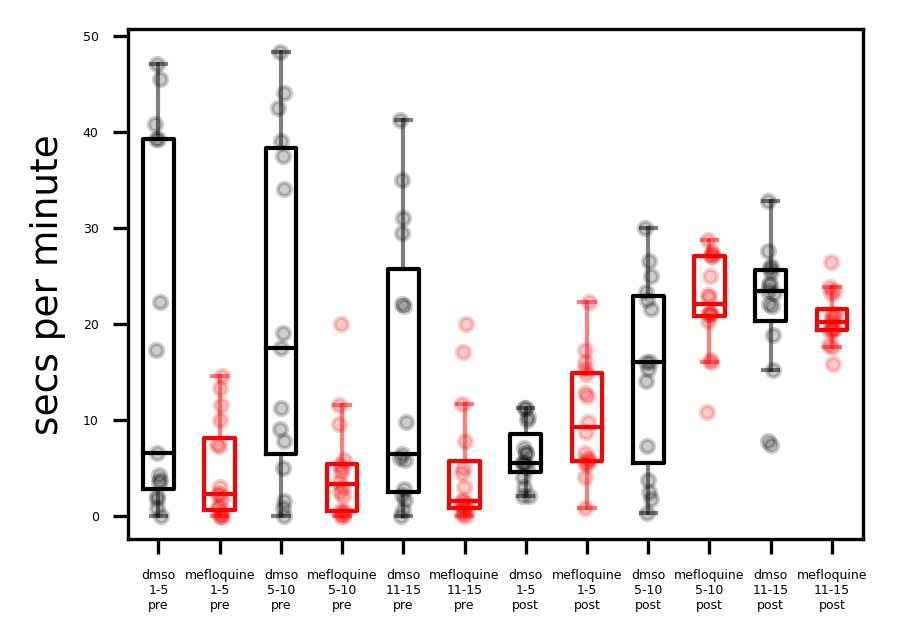

In [15]:
# MAKE THE BOXPLOT! (use data from directly above)

boxdata = secs_boxData_20
xlabs = secs_xlabs_20
ylab = 'secs per minute'
fname = 'secs_20.csv'

# width,height,markersize,label_fsize,tick_fsize,boxLineWeight
plotSizeParams = [3.16,2.25,10,9,3,1] 
bigBoxes(boxdata,xlabs,ylab,plotSizeParams,True)

## export data for stats

In [16]:
boxDataDict = {}
for i,arr in enumerate(boxdata):
    boxDataDict[secs_xlabs_0[i]] = boxdata[i]

In [17]:
# fill up arrays with nans
maxLen = 0
for (k,v) in boxDataDict.items():
    if len(v) > maxLen:
        maxLen = len(v)

for (k,v) in boxDataDict.items():
    if len(v) < maxLen:
        diff = maxLen - len(v)
        boxDataDict[k] = np.append(v, [np.nan]*diff)

In [18]:
boxDataDF = pd.DataFrame.from_dict(boxDataDict)

In [19]:
boxDataDF.to_csv('/Users/iwoods/Desktop/' + fname,sep = ',')

## ribbon plots for paper

In [23]:
# use data from above
predata = prepix_20
postdata = postpix_20
dmso = dmso_20
mefloquine = mefloquine_20
ylab = 'Average pixels per minute'

In [24]:
preDmso = predata[:,dmso]
preMef = predata[:,mefloquine]
postDmso = postdata[:,dmso]
postMef = postdata[:,mefloquine]

In [25]:
t = np.linspace(0,np.shape(predata)[0]-1, np.shape(predata)[0])
pre_t = t-max(t)
post_t = t

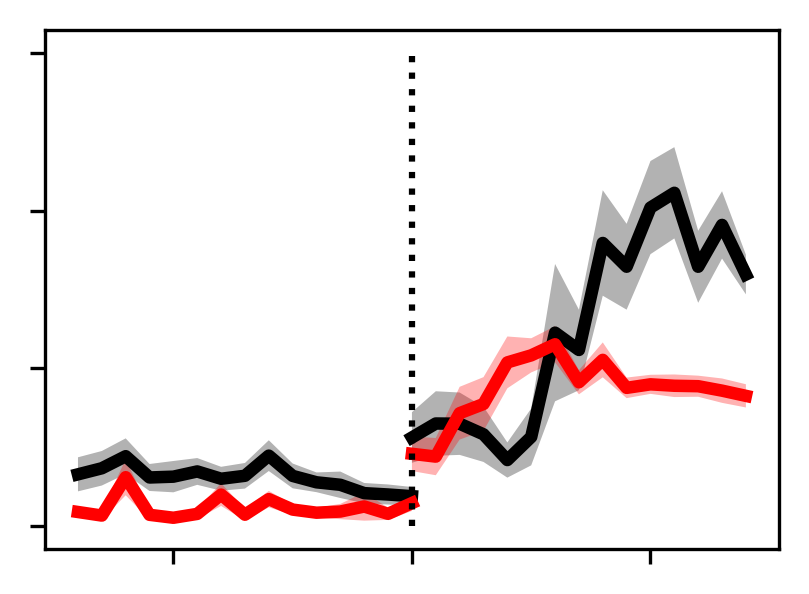

In [26]:
f,a = plt.subplots(1,1,figsize=(3.16,2.25),dpi=300)

pre_control = np.mean(preDmso,1)
pre_control_err = stde(preDmso,1)
post_control = np.mean(postDmso,1)
post_control_err = stde(postDmso,1)
col = 'k'

a.fill_between(pre_t, pre_control-pre_control_err, pre_control+pre_control_err, 
               alpha = 0.3, facecolor = col, label = 'DMSO')
a.plot(pre_t,np.mean(preDmso,1), color=col, linewidth = 3) 

a.fill_between(post_t, post_control-post_control_err, post_control+post_control_err, 
               alpha = 0.3, facecolor = col)
a.plot(post_t,np.mean(postDmso,1), color=col, linewidth = 3) 

pre_test = np.mean(preMef,1)
pre_test_err = stde(preMef,1)
post_test = np.mean(postMef,1)
post_test_err = stde(postMef,1)
col = 'r'

a.fill_between(pre_t, pre_test-pre_test_err, pre_test+pre_test_err, 
               alpha = 0.3, facecolor = col, label = 'Mefloquine')
a.plot(pre_t,np.mean(preMef,1), color=col, linewidth = 3) 

a.fill_between(post_t, post_test-post_test_err, post_test+post_test_err, 
               alpha = 0.3, facecolor = col)
a.plot(post_t,np.mean(postMef,1), color=col, linewidth = 3) 

yrange = a.get_ylim()
#a.plot([0,0],[yrange[0],yrange[1]],color='k',linestyle=':') # for pix

#plt.yticks([0, 250, 500, 750, 1000, 1250]) # pixels, sham
plt.yticks([0, 1000, 2000, 3000]) # pixels, 20 mM

#plt.yticks([0, 10, 20, 30, 40, 50 ]) # seconds, sham and 20 mM
a.plot([0,0],[0, 3000],color='k',linestyle=':') # for seconds

a.set_yticklabels([])
a.set_xticklabels([])

#plt.legend()
#a.set_ylabel(ylab)
#a.set_xlabel('time (minutes)')
#plt.title('20 mM')
plt.show()

# 20201010 ... rest period and seizure index (and all plots)

In [ ]:
predata = preseiz
postdata = postseiz
ylab = 'Pixels * Rest seconds per minute'

In [ ]:
preDmso = predata[:,dmso]
preMef = predata[:,mefloquine]
postDmso = postdata[:,dmso]
postMef = postdata[:,mefloquine]

In [ ]:
def fishAvgPerMin(d):
    return np.sum(d,0)/np.shape(d)[0]

In [ ]:
# just pre and post
boxData = [removenan(x) for x in [fishAvgPerMin(preDmso),fishAvgPerMin(preMef),
                                 fishAvgPerMin(postDmso),fishAvgPerMin(postMef)]]
xlabs = ['dmso\npre','mefloquine\npre','dmso\npost','mefloquine\npost']

In [ ]:
# 5 minute sections
preDmsoBeg = preDmso[:4,:]
preDmsoMid = preDmso[5:9,:]
preDmsoEnd = preDmso[10:,:]
preMefBeg = preMef[:4,:]
preMefMid = preMef[5:9,:]
preMefEnd = preMef[10:,:]

postDmsoBeg = postDmso[:4,:]
postDmsoMid = postDmso[5:9,:]
postDmsoEnd = postDmso[10:,:]
postMefBeg = postMef[:4,:]
postMefMid = postMef[5:9,:]
postMefEnd = postMef[10:,:]

boxData = [removenan(x) for x in [fishAvgPerMin(preDmsoBeg),fishAvgPerMin(preMefBeg),
                                  fishAvgPerMin(preDmsoMid),fishAvgPerMin(preMefMid),
                                  fishAvgPerMin(preDmsoEnd),fishAvgPerMin(preMefEnd),
                                  fishAvgPerMin(postDmsoBeg),fishAvgPerMin(postMefBeg),
                                  fishAvgPerMin(postDmsoMid),fishAvgPerMin(postMefMid),
                                  fishAvgPerMin(postDmsoEnd),fishAvgPerMin(postMefEnd)
                                 ]]
xlabs = ['dmso\n1-5\npre','mefloquine\n1-5\npre',
         'dmso\n5-10\npre','mefloquine\n5-10\npre',
         'dmso\n11-15\npre','mefloquine\n11-15\npre',
         'dmso\n1-5\npost','mefloquine\n1-5\npost',
         'dmso\n5-10\npost','mefloquine\n5-10\npost',
         'dmso\n11-15\npost','mefloquine\n11-15\npost']

In [ ]:
bigBoxes(boxData,xlabs,ylab)

In [ ]:
# can reset things here ...
# predata = preseiz
# postdata = postseiz
# ylab = 'Rest secs * pixels per minute'
# preDmso = predata[:,dmso]
# preMef = predata[:,mefloquine]
# postDmso = postdata[:,dmso]
# postMef = postdata[:,mefloquine]

In [ ]:
t = np.linspace(0,np.shape(predata)[0]-1, np.shape(predata)[0])
pre_t = t-max(t)
post_t = t

In [ ]:
f,ax = plt.subplots(1,figsize=(5,5))
a = 0.2

for fish in dmso:
    plt.plot(pre_t,predata[:,fish],color='k', alpha = a)

for fish in mefloquine:
    plt.plot(pre_t,predata[:,fish],color='r', alpha = a)
    
for fish in dmso:
    plt.plot(post_t,postdata[:,fish],color='k', alpha = a)

for fish in mefloquine:
    plt.plot(post_t,postdata[:,fish],color='r', alpha = a)

plt.plot(pre_t,np.mean(preDmso,1),color='k', linewidth = 3)  
plt.plot(pre_t,np.mean(preMef,1),color='r', linewidth = 3)  

plt.plot(post_t,np.mean(postDmso,1),color='k', linewidth = 3)  
plt.plot(post_t,np.mean(postMef,1),color='r', linewidth = 3)

yrange = ax.get_ylim()
ax.plot([0,0],[yrange[0],yrange[1]],color='k',linestyle=':')
ax.set_ylabel(ylab)
ax.set_xlabel('Minutes')
    
plt.show()

In [ ]:
f,a = plt.subplots(1,1,figsize=(5,5))

pre_control = np.mean(preDmso,1)
pre_control_err = stde(preDmso,1)
post_control = np.mean(postDmso,1)
post_control_err = stde(postDmso,1)
col = 'k'

a.fill_between(pre_t, pre_control-pre_control_err, pre_control+pre_control_err, 
               alpha = 0.3, facecolor = col, label = 'DMSO')
a.plot(pre_t,np.mean(preDmso,1), color=col, linewidth = 3) 

a.fill_between(post_t, post_control-post_control_err, post_control+post_control_err, 
               alpha = 0.3, facecolor = col)
a.plot(post_t,np.mean(postDmso,1), color=col, linewidth = 3) 

pre_test = np.mean(preMef,1)
pre_test_err = stde(preMef,1)
post_test = np.mean(postMef,1)
post_test_err = stde(postMef,1)
col = 'r'

a.fill_between(pre_t, pre_test-pre_test_err, pre_test+pre_test_err, 
               alpha = 0.3, facecolor = col, label = 'Mefloquine')
a.plot(pre_t,np.mean(preMef,1), color=col, linewidth = 3) 

a.fill_between(post_t, post_test-post_test_err, post_test+post_test_err, 
               alpha = 0.3, facecolor = col)
a.plot(post_t,np.mean(postMef,1), color=col, linewidth = 3) 

a.set_ylabel(ylab)
a.set_xlabel('time (minutes)')

yrange = a.get_ylim()
a.plot([0,0],[yrange[0],yrange[1]],color='k',linestyle=':')
plt.legend()
#plt.title('20 mM')
plt.show()

# 20201004 ... bin 5 minutes and boxplots

In [ ]:
dmso_20 = np.array([1, 5, 8, 11, 14, 16, 18, 20, 22, 24, 26, 32, 34, 36, 39]) # 20 mM ... omit 3, 28
mefloquine_20 = np.array([2, 4, 6, 10, 12, 15, 17, 19, 21, 23, 27, 30, 33, 35, 37, 40]) # 20 mM ... omit 25

dmso_0 = np.array([1, 3, 5, 7, 10, 13, 16, 18, 20, 22, 26, 32, 34, 36]) # sham
mefloquine_0 = np.array([2, 4, 8, 12, 15, 17, 19, 21, 25, 27, 33, 35, 40 ]) # sham ... omit 6

dmso = dmso_0
mefloquine = mefloquine_0

# correct for indexing!!!
dmso = dmso-1
mefloquine = mefloquine-1

In [ ]:
cd ~/Desktop/alyssa_1080p/200924_20mM_PTZ_pre/

In [ ]:
prebinnedData, prebinsWithMotion, prebinnedTime = loadAndBinData('xy2',1)

In [ ]:
cd ~/Desktop/alyssa_1080p/200924_20mM_PTZ_post/

In [ ]:
postbinnedData, postbinsWithMotion, postbinnedTime = loadAndBinData('xy2',1)

In [ ]:
preData = prebinnedData
postData = postbinnedData
ylab = 'Pixels per minute'

In [ ]:
# preData = prebinsWithMotion
# postData = postbinsWithMotion
# ylab = 'Seconds moved per minute'

In [ ]:
pre_bin1 = preData[:299,:]
pre_bin2 = preData[300:599,:]
pre_bin3 = preData[600:,:]
post_bin1 = postData[:299,:]
post_bin2 = postData[300:599,:]
post_bin3 = postData[600:,:]

In [ ]:
dmso_pre_bin1 = np.sum(pre_bin1[:,dmso],0)/5
dmso_pre_bin2 = np.sum(pre_bin2[:,dmso],0)/5
dmso_pre_bin3 = np.sum(pre_bin3[:,dmso],0)/5
dmso_post_bin1 = np.sum(post_bin1[:,dmso],0)/5
dmso_post_bin2 = np.sum(post_bin2[:,dmso],0)/5
dmso_post_bin3 = np.sum(post_bin3[:,dmso],0)/5

mefloquine_pre_bin1 = np.sum(pre_bin1[:,mefloquine],0)/5
mefloquine_pre_bin2 = np.sum(pre_bin2[:,mefloquine],0)/5
mefloquine_pre_bin3 = np.sum(pre_bin3[:,mefloquine],0)/5
mefloquine_post_bin1 = np.sum(post_bin1[:,mefloquine],0)/5
mefloquine_post_bin2 = np.sum(post_bin2[:,mefloquine],0)/5
mefloquine_post_bin3 = np.sum(post_bin3[:,mefloquine],0)/5

In [ ]:
f,a = plt.subplots(1,1,figsize = (12,6))
plt.style.use('default')

# seconds per minute
boxData = [removenan(x) for x in [dmso_pre_bin1,mefloquine_pre_bin1,
                                 dmso_pre_bin2,mefloquine_pre_bin2,
                                 dmso_pre_bin3,mefloquine_pre_bin3,
                                 dmso_post_bin1,mefloquine_post_bin1,
                                 dmso_post_bin2,mefloquine_post_bin2,
                                 dmso_post_bin3,mefloquine_post_bin3]
          ]

numreps = int(len(boxData)/2)

plotColors = ['k','r'] * numreps

bp = a.boxplot(boxData,showfliers=False)

bp = formatBoxColors(bp, plotColors)

xPos = 1 
for b in boxData:
    numPoints = len(b)
    xPoints=wobbleAround(xPos,numPoints,0.05)
    # add the points!
    plt.scatter(xPoints,b,c=plotColors[xPos-1],edgecolor=plotColors[xPos-1],alpha=0.2,s=50)
    xPos += 1

plt.ylabel(ylab,fontsize=12)
xlabs = ['dmso\npre\n0-5',  'mefloquine\npre\n0-5',
        'dmso\npre\n6-10',  'mefloquine\npre\n6-10',
        'dmso\npre\n11-15', 'mefloquine\npre\n11-15',
        'dmso\npost\n0-5',  'mefloquine\npost\n0-5',
        'dmso\npost\n6-10', 'mefloquine\npost\n6-10',
        'dmso\npost\n11-15','mefloquine\npost\n11-15']
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12],xlabs,fontsize=10)
plt.show()

# 20201004 show movement paths in 5 minute bins

In [ ]:
from matplotlib import cm

def make_N_colors(cmap_name, N):
    cmap = cm.get_cmap(cmap_name, N)
    colors = [list(cmap(i)) for i in np.linspace(0, 1, N)]
    return colors

def showAllTraces(data,figname='allTraces.png'):
    # note that this takes a LONG time to plot big datasets, b/c each frame is on plot
    # saving as image takes less time
    print('Plotting trace data for all ROI')
    figWidth = 12
    figHeight = 8
    dotsPerInch = 80
    f = plt.figure(num=None, figsize=(figWidth,figHeight), dpi=dotsPerInch, facecolor='w', edgecolor='k')
    numROI = int(np.shape(data[:,1:])[1]/2)
    roiColors = make_N_colors('rainbow', numROI)
    for d in range(numROI):
        dotColor = roiColors[d]
        xdata = data[:,d+1]
        ydata = (figHeight*dotsPerInch)-data[:,d+1+numROI]
        plt.scatter(xdata,ydata, facecolor = dotColor, s=2, alpha = 0.2)
    plt.xticks([]),plt.yticks([])
    plt.axis('equal')

    plt.savefig(figname)
    print('Saving figure ' + figname)
    if np.shape(data)[0] < 50000:
        plt.show()
    else:
        print('See saved figure; too big to plot')

In [ ]:
cd ~/Desktop/alyssa_1080p/200924_20mM_PTZ_pre/

In [ ]:
d = loadData('xy2')

In [ ]:
print(np.shape(d))

In [ ]:
print(np.shape(d)[0]/3)

In [ ]:
prebin1 = d[:8992,:]
prebin2 = d[8993:17984,:]
prebin3 = d[17984:,:]

In [ ]:
cd ~/Desktop/alyssa_1080p/200924_20mM_PTZ_post/

In [ ]:
d = loadData('xy2')

In [ ]:
print(np.shape(d)[0]/3)

In [ ]:
postbin1 = d[:8992,:]
postbin2 = d[8993:17984,:]
postbin3 = d[17984:,:]

In [ ]:
showAllTraces(postbin3,'post3_traces')

In [ ]:
# figure out how to draw circles based on genotypes . . . 

# 20201004 plot time vs. activity individual fish

In [ ]:
binsize = 1 # in seconds
binsPerMinute = 60 / binsize # don't change

In [ ]:
cd ~/Desktop/alyssa_1080p/200924_20mM_PTZ_pre/

In [ ]:
pre_bd, pre_bm, bt = loadAndBinData('xy2',binsize)

t = np.linspace(0,np.shape(pre_bd)[0] / binsPerMinute, np.shape(pre_bd)[0])
pre_t = t-max(t)

In [ ]:
cd ~/Desktop/alyssa_1080p/200924_20mM_PTZ_post/

In [ ]:
post_bd, post_bm, bt = loadAndBinData('xy2',binsize)

t = np.linspace(0,np.shape(pre_bd)[0] / binsPerMinute, np.shape(pre_bd)[0])
post_t = t

In [ ]:
dmso = np.array([1, 5, 8, 11, 14, 16, 18, 20, 22, 24, 26, 32, 34, 36, 39]) # 20 mM ... omit 3, 28
mefloquine = np.array([2, 4, 6, 10, 12, 15, 17, 19, 21, 23, 27, 30, 33, 35, 37, 40]) # 20 mM ... omit 25

In [ ]:
# correct for indexing!!!!
dmso = dmso-1
mefloquine = mefloquine-1

In [ ]:
pre = pre_bd
post = post_bd
ylab = 'pixels per minute'

# pre = pre_bm
# post = post_bm
# ylab = 'seconds moved per minute'

pre_dmso = np.mean(pre[:,dmso],1)
pre_mefloquine = np.mean(pre[:,mefloquine],1)
post_dmso = np.mean(post[:,dmso],1)
post_mefloquine = np.mean(post[:,mefloquine],1)

In [ ]:
f,ax = plt.subplots(1,figsize=(8,5))
a = 0.2

for fish in dmso:
    plt.plot(pre_t,pre[:,fish],color='k', alpha = a)

for fish in mefloquine:
    plt.plot(pre_t,pre[:,fish],color='r', alpha = a)
    
for fish in dmso:
    plt.plot(post_t,post[:,fish],color='k', alpha = a)

for fish in mefloquine:
    plt.plot(post_t,post[:,fish],color='r', alpha = a)

plt.plot(pre_t,pre_dmso,color='k', linewidth = 3)  
plt.plot(pre_t,pre_mefloquine,color='r', linewidth = 3)  

plt.plot(post_t,post_dmso,color='k', linewidth = 3)  
plt.plot(post_t,post_mefloquine,color='r', linewidth = 3)

yrange = ax.get_ylim()
ax.plot([0,0],[yrange[0],yrange[1]],color='k',linestyle=':')
ax.set_ylabel(ylab)
    
plt.show()

# 20200924 ... 48 well plates with multiple treatments per plate

### ribbon plots

In [ ]:
# enter the different kinds of fish here
dmso_0 = np.array([1, 3, 5, 7, 10, 13, 16, 18, 20, 22, 26, 32, 34, 36]) # sham
mefloquine_0 = np.array([2, 4, 8, 12, 15, 17, 19, 21, 25, 27, 33, 35, 40 ]) # sham ... omit 6
dmso_5 = np.array([2, 4, 6, 8, 10, 12, 14, 20, 22, 25, 27, 30, 32, 36, 38]) # 5 mM ... omit 17
mefloquine_5 = np.array([1, 3, 5, 7, 9, 13, 15, 19, 21, 24, 26, 28, 31, 33, 37, 39]) # 5 mM ... omit 11
dmso_20 = np.array([1, 5, 8, 11, 14, 16, 18, 20, 22, 24, 26, 32, 34, 36, 39]) # 20 mM ... omit 3, 28
mefloquine_20 = np.array([2, 4, 6, 10, 12, 15, 17, 19, 21, 23, 27, 30, 33, 35, 37, 40]) # 20 mM ... omit 25

In [ ]:
cd ~/Desktop/alyssa_1080p/200924_sham_pre/

In [ ]:
pre_avg,pre_err,ylab = getDataForPlot('pix', genotypes = [dmso_0,mefloquine_0])

In [ ]:
cd ~/Desktop/alyssa_1080p/200924_sham_post/

In [ ]:
post_avg,post_err,ylab = getDataForPlot('pix', genotypes = [dmso_0,mefloquine_0])

In [ ]:
# plot of binned data, control vs test, with fill = +/- standard error of the mean
f,a = plt.subplots(1,1)
t = np.linspace(-14,0,15)
t2 = t + 14
col = 'k'

pre_control = pre_avg[0]
pre_test = pre_avg[1]
pre_control_err = pre_err[0]
pre_test_err = pre_err[1]

post_control = post_avg[0]
post_test = post_avg[1]
post_control_err = post_err[0]
post_test_err = post_err[1]

a.plot(t,pre_control,color=col)
a.fill_between(t, pre_control-pre_control_err, pre_control+pre_control_err, 
               alpha = 0.3, facecolor = col, label = 'DMSO')

a.plot(t2,post_control,color=col)
a.fill_between(t2, post_control-post_control_err, post_control+post_control_err, 
               alpha = 0.3, facecolor = col)

col = 'r'
a.plot(t,pre_test,color=col)
a.fill_between(t, pre_test-pre_test_err, pre_test+pre_test_err, 
               alpha = 0.3, facecolor = col, label = 'Mefloquine')

a.plot(t2,post_test,color=col)
a.fill_between(t2, post_test-post_test_err, post_test+post_test_err, 
               alpha = 0.3, facecolor = col)

a.set_ylabel(ylab)
a.set_xlabel('time (minutes)')

yrange = a.get_ylim()
a.plot([0,0],[yrange[0],yrange[1]],color='k',linestyle=':')
plt.legend()
plt.title('0 mM')
plt.show()

### boxplots

In [ ]:
# enter the different kinds of fish here
dmso_0 = np.array([1, 3, 5, 7, 10, 13, 16, 18, 20, 22, 26, 32, 34, 36]) # sham
mefloquine_0 = np.array([2, 4, 8, 12, 15, 17, 19, 21, 25, 27, 33, 35, 40 ]) # sham ... omit 6
dmso_5 = np.array([2, 4, 6, 8, 10, 12, 14, 20, 22, 25, 27, 30, 32, 36, 38]) # 5 mM ... omit 17
mefloquine_5 = np.array([1, 3, 5, 7, 9, 13, 15, 19, 21, 24, 26, 28, 31, 33, 37, 39]) # 5 mM ... omit 11
dmso_20 = np.array([1, 5, 8, 11, 14, 16, 18, 20, 22, 24, 26, 32, 34, 36, 39]) # 20 mM ... omit 3, 28
mefloquine_20 = np.array([2, 4, 6, 10, 12, 15, 17, 19, 21, 23, 27, 30, 33, 35, 37, 40]) # 20 mM ... omit 25

In [ ]:
def prepData():
    vidInfo = getVidInfo()
    print('fps',vidInfo['fps'])
    print('num frames',vidInfo['numFrames'])
    print('video length',vidInfo['vidLength'])

    d = loadData('xy2')
    print(np.shape(d)) # should match frame number in vidInfo

    # fix timestamps in recorded video
    # set start time to be midnight of today + 1 second
    d = fixTimeStamps(d,vidInfo)

    # convert XY data to distances
    distances = convertXYDataToDistances(d)

    binnedData, binnedTime = binData(distances,1,vidInfo['vidLength'])

    print(np.shape(binnedData))
    numMinutes = np.shape(binnedData)[0] / 60.0
    print(numMinutes)
    
    binsWithMotion = (binnedData>0).astype(int)
    
    return binnedData, binsWithMotion, binnedTime

In [ ]:
cd /Users/iwoods/Desktop/alyssa_1080p/200924_sham_pre

In [ ]:
binnedData, binsWithMotion, binnedTime = prepData()
dmso_0_pre_pix = np.sum(binnedData[:,dmso_0],axis=0)/15
dmso_0_pre_secs = np.sum(binsWithMotion[:,dmso_0],axis=0)/15
mef_0_pre_pix = np.sum(binnedData[:,mefloquine_0],axis=0)/15
mef_0_pre_secs = np.sum(binsWithMotion[:,mefloquine_0],axis=0)/15

In [ ]:
cd /Users/iwoods/Desktop/alyssa_1080p/200924_sham_post

In [ ]:
binnedData, binsWithMotion, binnedTime = prepData()
dmso_0_post_pix = np.sum(binnedData[:,dmso_0],axis=0)/15
dmso_0_post_secs = np.sum(binsWithMotion[:,dmso_0],axis=0)/15
mef_0_post_pix = np.sum(binnedData[:,mefloquine_0],axis=0)/15
mef_0_post_secs = np.sum(binsWithMotion[:,mefloquine_0],axis=0)/15

In [ ]:
cd /Users/iwoods/Desktop/alyssa_1080p/200924_5mM_PTZ_pre

In [ ]:
binnedData, binsWithMotion, binnedTime = prepData()
dmso_5_pre_pix = np.sum(binnedData[:,dmso_5],axis=0)/15
dmso_5_pre_secs = np.sum(binsWithMotion[:,dmso_5],axis=0)/15
mef_5_pre_pix = np.sum(binnedData[:,mefloquine_5],axis=0)/15
mef_5_pre_secs = np.sum(binsWithMotion[:,mefloquine_5],axis=0)/15

In [ ]:
cd /Users/iwoods/Desktop/alyssa_1080p/200924_5mM_PTZ_post

In [ ]:
binnedData, binsWithMotion, binnedTime = prepData()
dmso_5_post_pix = np.sum(binnedData[:,dmso_5],axis=0)/15
dmso_5_post_secs = np.sum(binsWithMotion[:,dmso_5],axis=0)/15
mef_5_post_pix = np.sum(binnedData[:,mefloquine_5],axis=0)/15
mef_5_post_secs = np.sum(binsWithMotion[:,mefloquine_5],axis=0)/15

In [ ]:
cd /Users/iwoods/Desktop/alyssa_1080p/200924_20mM_PTZ_pre

In [ ]:
binnedData, binsWithMotion, binnedTime = prepData()
dmso_20_pre_pix = np.sum(binnedData[:,dmso_20],axis=0)/15
dmso_20_pre_secs = np.sum(binsWithMotion[:,dmso_20],axis=0)/15
mef_20_pre_pix = np.sum(binnedData[:,mefloquine_20],axis=0)/15
mef_20_pre_secs = np.sum(binsWithMotion[:,mefloquine_20],axis=0)/15

In [ ]:
cd /Users/iwoods/Desktop/alyssa_1080p/200924_20mM_PTZ_post

In [ ]:
binnedData, binsWithMotion, binnedTime = prepData()
dmso_20_post_pix = np.sum(binnedData[:,dmso_20],axis=0)/15
dmso_20_post_secs = np.sum(binsWithMotion[:,dmso_20],axis=0)/15
mef_20_post_pix = np.sum(binnedData[:,mefloquine_20],axis=0)/15
mef_20_post_secs = np.sum(binsWithMotion[:,mefloquine_20],axis=0)/15

In [ ]:
f,a = plt.subplots(1,1,figsize = (12,6))
plt.style.use('default')

# seconds per minute
boxData = [removenan(x) for x in [dmso_0_pre_secs,mef_0_pre_secs,dmso_0_post_secs,mef_0_post_secs,
                                 dmso_5_pre_secs,mef_5_pre_secs,dmso_5_post_secs,mef_5_post_secs,
                                 dmso_20_pre_secs,mef_20_pre_secs,dmso_20_post_secs,mef_20_post_secs]]
ylab = 'Seconds moved per minute'

# pixels per minute
# boxData = [removenan(x) for x in [dmso_0_pre_pix,mef_0_pre_pix,dmso_0_post_pix,mef_0_post_pix,
#                                  dmso_5_pre_pix,mef_5_pre_pix,dmso_5_post_pix,mef_5_post_pix,
#                                  dmso_20_pre_pix,mef_20_pre_pix,dmso_20_post_pix,mef_20_post_pix]]
# ylab = 'Movement (pixels) per minute'

numreps = int(len(boxData)/2)
print(numreps)
plotColors = ['k','r'] * numreps

bp = a.boxplot(boxData,showfliers=False)

bp = formatBoxColors(bp, plotColors)

xPos = 1 
for b in boxData:
    numPoints = len(b)
    xPoints=wobbleAround(xPos,numPoints,0.05)
    # add the points!
    plt.scatter(xPoints,b,c=plotColors[xPos-1],edgecolor=plotColors[xPos-1],alpha=0.2,s=50)
    xPos += 1

plt.ylabel(ylab,fontsize=12)
xlabs = ['DMSO\nsham\npre','Mefloquine\nsham\npre','DMSO\nsham\npost','Mefloquine\nsham\npost',
         'DMSO\n5 mM\npre','Mefloquine\n5 mM\npre','DMSO\n5 mM\npost','Mefloquine\n5 mM\npost',
         'DMSO\n20 mM\npre','Mefloquine\n20 mM\npre','DMSO\n20 mM\npost','Mefloquine\n20 mM\npost'
        ]
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12],xlabs,fontsize=10)
plt.show()

In [ ]:
vidInfo = getVidInfo()
print('fps',vidInfo['fps'])
print('num frames',vidInfo['numFrames'])
print('video length',vidInfo['vidLength'])

d = loadData('xy2')
print(np.shape(d)) # should match frame number in vidInfo

# fix timestamps in recorded video
# set start time to be midnight of today + 1 second
d = fixTimeStamps(d,vidInfo)

# convert XY data to distances
distances = convertXYDataToDistances(d)

binnedData, binnedTime = binData(distances,1,vidInfo['vidLength'])

print(np.shape(binnedData))
numMinutes = np.shape(binnedData)[0] / 60.0
print(numMinutes)

In [ ]:
print(binnedData[:14,14:20])

In [ ]:
# show overall motion ... any bumps?
timeVmotion = np.mean(binnedData,1)
plt.plot(timeVmotion)
plt.xlabel('Time (video frames)')
plt.ylabel('Motion (displaced pixels)')
plt.show()

In [ ]:
# show overall activity in plate ... are there any dead fish that should be omitted?
# is the difference in illumination across the plate causing big problems?
totalActivity = np.sum(binnedData,0)

plateView = np.reshape(totalActivity,(6,8))
plt.imshow(plateView, interpolation='nearest', cmap = 'gray')
columns = np.array([1,2,3,4,5,6,7,8])
rows = ['a','b','c','d','e','f']
plt.xticks(columns-1, columns)
plt.yticks([0,1,2,3,4,5],rows) # or other way?
plt.show()

In [ ]:
binsWithMotion = (binnedData>0).astype(int)
print(np.shape(binsWithMotion))
print(np.shape(binnedData))

In [ ]:
# plot of binned data, control vs test
dmsoData = binnedData[:,dmso]
mefloquineData = binnedData[:,mefloquine]

dmsoSecsMoved = binsWithMotion[:,dmso]
mefloquineSecsMoved = binsWithMotion[:,mefloquine]

control = dmsoData
test = mefloquineData

meanControl = np.mean(control,1)
meanTest = np.mean(test,1)
plt.plot(binnedTime,meanControl,'k')
plt.plot(binnedTime,meanTest,'r')
plt.xlabel('time (s)')
plt.ylabel('motion (pixels)')
plt.show()

In [ ]:
avg,err,ylab = getDataForPlot(dataType='pix')

In [ ]:
print(len(err))

# 12 well data analysis, one treatment per plate

In [ ]:
# seconds of motion per minute
for x in np.sum(binsWithMotion,0)/numMinutes:
    print(str(x))

In [ ]:
# distance (in pixels) moved per minute
for x in np.sum(binnedData,0)/numMinutes:
    print(str(x))

# ribbon plots

In [ ]:
cd ~/Desktop/alyssa_1080p/2_pre/

In [ ]:
# get data for ribbon plot
avg1,err1,ylab = getDataForPlot('pix')
print(avg1)
print(err1)

In [ ]:
cd ~/Desktop/alyssa_1080p/2_post/

In [ ]:
avg2,err2,ylab = getDataForPlot('pix')
print(avg2)
print(err2)

In [ ]:
cd ~/Desktop/alyssa_1080p/4_pre/

In [ ]:
avg3,err3,ylab = getDataForPlot('pix')
print(avg3)
print(err3)

In [ ]:
cd ~/Desktop/alyssa_1080p/4_post/

In [ ]:
avg4,err4,ylab = getDataForPlot('pix')
print(avg4)
print(err4)

In [ ]:
# plot of binned data, control vs test, with fill = +/- standard error of the mean
f,a = plt.subplots(1,1)
t = np.linspace(-14,0,15)
t2 = t + 14
col = 'k'

a.plot(t,avg1,color=col)
a.fill_between(t, avg1-err1, avg1+err1, alpha = 0.3, facecolor = col, label = 'DMSO')

a.plot(t2,avg2,color=col)
a.fill_between(t2, avg2-err2, avg2+err2, alpha = 0.3, facecolor = col)

col = 'r'
a.plot(t,avg3,color=col)
a.fill_between(t, avg3-err3, avg3+err3, alpha = 0.3, facecolor = col, label = 'Mefloquine')

a.plot(t2,avg4,color=col)
a.fill_between(t2, avg4-err4, avg4+err4, alpha = 0.3, facecolor = col)

a.set_ylabel(ylab)
a.set_xlabel('time (minutes)')

yrange = a.get_ylim()
a.plot([0,0],[yrange[0],yrange[1]],color='k',linestyle=':')
plt.legend()
plt.title('20 mM')
plt.show()

# compare pairs

In [ ]:
cd ~/Desktop/alyssa_1080p

In [ ]:
dd = pd.read_csv('200903_1080p.csv',delimiter = ',')
dd

In [ ]:
pre = dd.DMSO_sham_PTZ_pre_secs.values
post = dd.DMSO_sham_PTZ_post_secs.values

boxData = [removenan(x) for x in [pre,post]]
bp = plt.boxplot(boxData,showfliers=False)
plotColors = ['k','r']
bp = formatBoxColors(bp, plotColors)

xPos = 1 
for b in boxData:
    numPoints = len(b)
    xPoints=wobbleAround(xPos,numPoints,0.05)
    # add the points!
    plt.scatter(xPoints,b,c=plotColors[xPos-1],edgecolor=plotColors[xPos-1],alpha=0.2,s=50)
    xPos += 1

plt.ylabel('Seconds with motion\nper minute',fontsize=16)
#plt.ylabel('Distance (pixels) per minute',fontsize=16)
plt.xticks([1,2],['pre','post'],fontsize=16)
plt.show()

# compare all groups

In [ ]:
cd ~/Desktop/alyssa_1080p

In [ ]:
dd = pd.read_csv('200903_1080p.csv',delimiter = ',')
dd

In [ ]:
pre1 =  dd.DMSO_sham_PTZ_pre_secs
post1 =  dd.DMSO_sham_PTZ_post_secs
pre2 =  dd.DMSO_5mM_PTZ_pre_secs
post2 =  dd.DMSO_5mM_PTZ_post_secs
pre3 =  dd.DMSO_20mM_PTZ_pre_secs
post3 =  dd.DMSO_20mM_PTZ_post_secs
pre4 =  dd.Mefloquine_sham_PTZ_pre_secs
post4 =  dd.Mefloquine_sham_PTZ_post_secs
pre5 = dd.Mefloquine_5mM_PTZ_pre_secs
post5 = dd.Mefloquine_5mM_PTZ_post_secs
pre6 = dd.Mefloquine_20mM_PTZ_pre_secs
post6 = dd.Mefloquine_20mM_PTZ_post_secs
ylab = 'Seconds with motion\nper minute'

In [ ]:
pre1 =  dd.DMSO_sham_PTZ_pre_pix
post1 =  dd.DMSO_sham_PTZ_post_pix
pre2 =  dd.DMSO_5mM_PTZ_pre_pix
post2 =  dd.DMSO_5mM_PTZ_post_pix
pre3 =  dd.DMSO_20mM_PTZ_pre_pix
post3 =  dd.DMSO_20mM_PTZ_post_pix
pre4 =  dd.Mefloquine_sham_PTZ_pre_pix
post4 =  dd.Mefloquine_sham_PTZ_post_pix
pre5 = dd.Mefloquine_5mM_PTZ_pre_pix
post5 = dd.Mefloquine_5mM_PTZ_post_pix
pre6 = dd.Mefloquine_20mM_PTZ_pre_pix
post6 = dd.Mefloquine_20mM_PTZ_post_pix
ylab = 'Seconds with motion\nper minute'
ylab = 'Distance (pixels) per minute'

In [ ]:
f,a = plt.subplots(1,1,figsize = (12,6))
plt.style.use('default')
boxData = [removenan(x) for x in [pre1,post1,pre2,post2,pre3,post3,
                                  pre4,post4,pre5,post5,pre6,post6]]
numreps = int(len(boxData)/2)
print(numreps)
plotColors = ['k','r'] * numreps

bp = a.boxplot(boxData,showfliers=False)

bp = formatBoxColors(bp, plotColors)

xPos = 1 
for b in boxData:
    numPoints = len(b)
    xPoints=wobbleAround(xPos,numPoints,0.05)
    # add the points!
    plt.scatter(xPoints,b,c=plotColors[xPos-1],edgecolor=plotColors[xPos-1],alpha=0.2,s=50)
    xPos += 1

plt.ylabel(ylab,fontsize=12)
xlabs = ['DMSO\nsham\npre','DMSO\nsham\npost',
         'DMSO\n5mM\npre','DMSO\n5mM\npost',
         'DMSO\n20mM\npre','DMSO\n20mM\npost',
         'Mefloquine\nsham\npre','Mefloquine\nsham\npost',
         'Mefloquine\n5mM\npre','Mefloquine\n5mM\npost',
         'Mefloquine\n20mM\npre','Mefloquine\n20mM\npost']
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12],xlabs,fontsize=10)
plt.show()

# compare different runs

In [ ]:
cd ~/Desktop/alyssa/720pix/

In [ ]:
tw = pd.read_csv('tryscatter.csv',delimiter = ',')
tw

In [ ]:
plt.scatter(tw.fr_pre1_secs_motion_per_minute,tw.pre1_secs_motion_per_minute)
plt.show()